In [61]:
# LSTM Modeling for Time-Series Stock Price Forecasting
# Objective: Use Long Short-Term Memory (LSTM) networks to predict stock prices based on sequential data.


In [62]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input


In [63]:
# Load the dataset
# Ensure the dataset has a 'Date' column and a 'Close' column
data = pd.read_csv('data/AAPL_data_with_beta.csv')

# Inspect the first few rows to confirm proper loading
print("Dataset Preview:")
print(data.head())


# Select the column to predict (e.g., 'Close' price) and handle missing values
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
data.dropna(subset=['Close'], inplace=True)
close_prices = data['Close'].values.reshape(-1, 1)

# Normalize the data to a range of 0 to 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)



Dataset Preview:
         Date          Adj Close              Close               High  \
0         NaN               AAPL               AAPL               AAPL   
1  2020-01-02   72.7960205078125   75.0875015258789   75.1500015258789   
2  2020-01-03   72.0882797241211  74.35749816894531   75.1449966430664   
3  2020-01-06  72.66270446777344  74.94999694824219  74.98999786376953   
4  2020-01-07  72.32097625732422  74.59750366210938   75.2249984741211   

                 Low               Open     Volume  Stock Return  Rolling Beta  
0               AAPL               AAPL       AAPL           NaN           NaN  
1  73.79750061035156  74.05999755859375  135480400           NaN           NaN  
2             74.125   74.2874984741211  146322800     -0.009722           NaN  
3            73.1875  73.44750213623047  118387200      0.007968           NaN  
4  74.37000274658203  74.95999908447266  108872000     -0.004703           NaN  


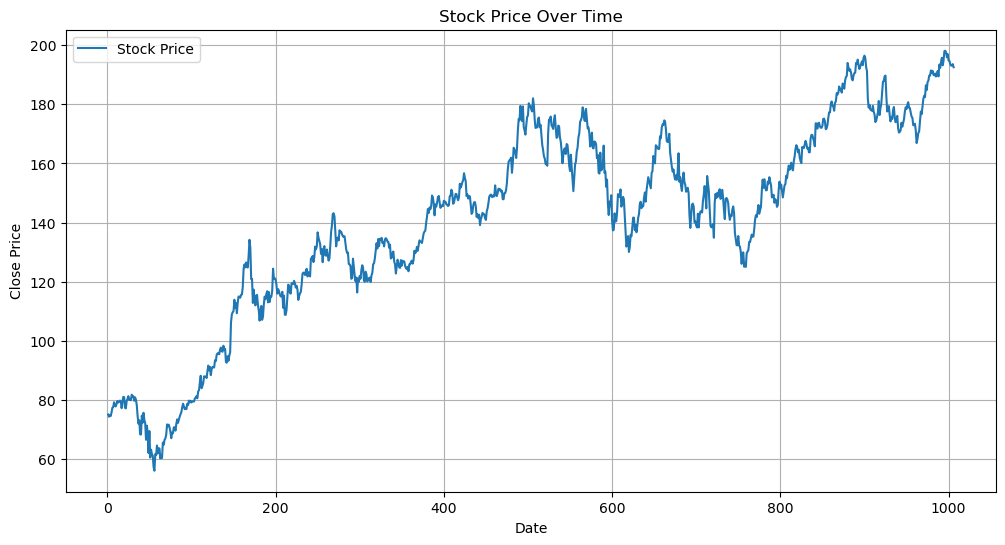

In [64]:
# Visualize the stock price trend
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Stock Price')
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [65]:
# Define function to create a dataset with time steps for LSTM
def create_sequences(data, time_step=60):
    """
    Convert the dataset into sequences of input and target variables.

    Parameters:
    - data: Scaled dataset as a numpy array
    - time_step: Number of time steps to consider for each input sequence

    Returns:
    - X, y: Input features and corresponding target variables
    """
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])  # Previous 'time_step' data points
        y.append(data[i + time_step, 0])   # Target is the next data point
    return np.array(X), np.array(y)

# Create sequences with a time step of 60 (e.g., 60 days)
time_step = 60
X, y = create_sequences(scaled_data, time_step)

# Reshape input to be [samples, time_steps, features] as required by LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (756, 60, 1)
Testing set size: (190, 60, 1)


In [66]:
# Build the LSTM model
model = Sequential([
    Input(shape=(time_step, 1)),  # Define the input shape explicitly
    LSTM(50, return_sequences=True),  # First LSTM layer
    Dropout(0.2),  # Dropout for regularization
    LSTM(50, return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(25),  # Dense layer with 25 neurons
    Dense(1)    # Output layer for the predicted price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# time_step=60 means the model will use 60 previous days to predict the next day.
# epochs=50 and batch_size=32 are chosen as a trade-off between training time and performance.


In [68]:
# Train the model
# Use validation data to monitor the model's performance on unseen data
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=1
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.1262 - val_loss: 0.0220
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0070 - val_loss: 0.0038
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0057 - val_loss: 0.0084
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0

In [69]:
# Validation Loss Fluctuations
# The validation loss increases intermittently during training. This might indicate:
# A) Learning rate that is too high.
# B) Need for an early stopping mechanism to prevent overfitting.
# Therefore we will be implement EarlyStopping from Keras

In [70]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Stop if no improvement for 10 epochs
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping], 
    verbose=1
)


Epoch 1/50


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - val_loss: 9.5154e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0015 - val_loss: 6.5805e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0014 - val_loss: 6.1359e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - val_loss: 9.1902e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - val_loss: 7.6354e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - val_loss: 8.8227e-04
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/ste

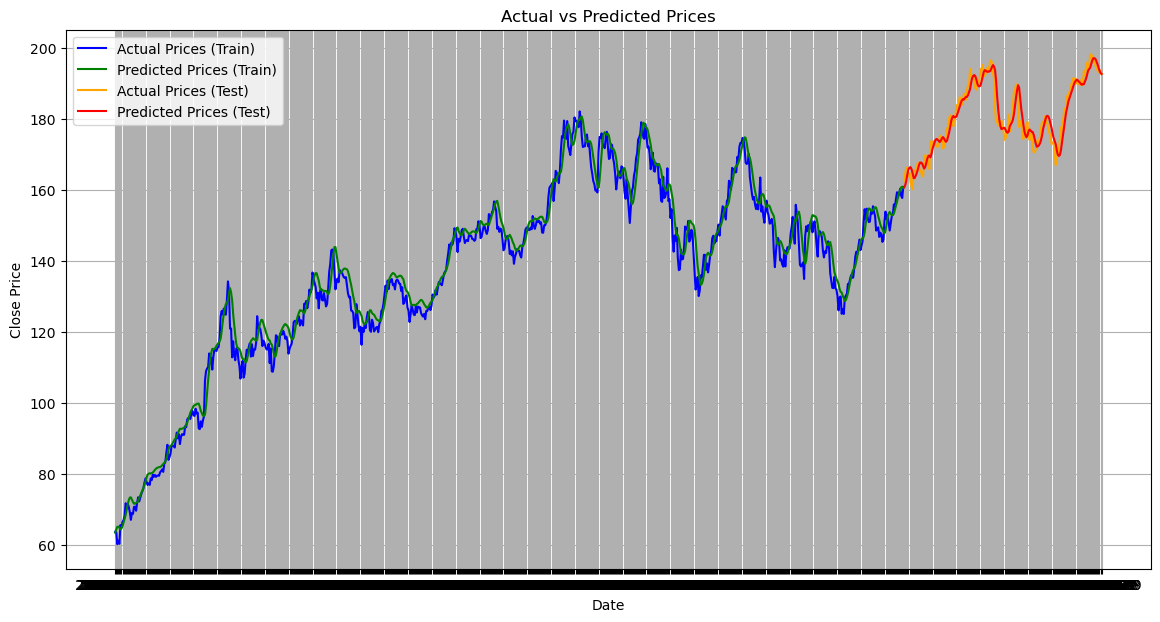

In [71]:
# Flatten the predictions and original values to remove the extra dimension
# This step ensures that predictions and actual values are 1-dimensional arrays for proper alignment during plotting
test_predictions = test_predictions.flatten()  # Flatten the test predictions array
y_test_original = y_test_original.flatten()    # Flatten the original test values array
train_predictions = train_predictions.flatten()  # Flatten the train predictions array
y_train_original = y_train_original.flatten()    # Flatten the original train values array

# Adjust the test_dates to match the length of the testing predictions
# This ensures the dates align correctly with the actual and predicted values for the test set
test_dates = data['Date'].iloc[train_size + time_step:train_size + time_step + len(y_test_original)]

# Plot the training and testing results
# This visualization helps compare actual vs predicted prices for both training and testing datasets
plt.figure(figsize=(14, 7))  
plt.plot(train_dates, y_train_original, label='Actual Prices (Train)', color='blue')  # Actual prices during training
plt.plot(train_dates, train_predictions, label='Predicted Prices (Train)', color='green')  # Predicted prices during training
plt.plot(test_dates, y_test_original, label='Actual Prices (Test)', color='orange')  # Actual prices during testing
plt.plot(test_dates, test_predictions, label='Predicted Prices (Test)', color='red')  # Predicted prices during testing
plt.title("Actual vs Predicted Prices")  
plt.xlabel("Date")  
plt.ylabel("Close Price")  
plt.legend()  
plt.grid(True)  # Enable grid for better visual guidance
plt.show()  


In [72]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Reverse scaling to get original price values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [73]:
# Evaluate the model's performance
train_mae = mean_absolute_error(y_train_original, train_predictions)
test_mae = mean_absolute_error(y_test_original, test_predictions)
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

Training MAE: 3.82
Testing MAE: 2.68


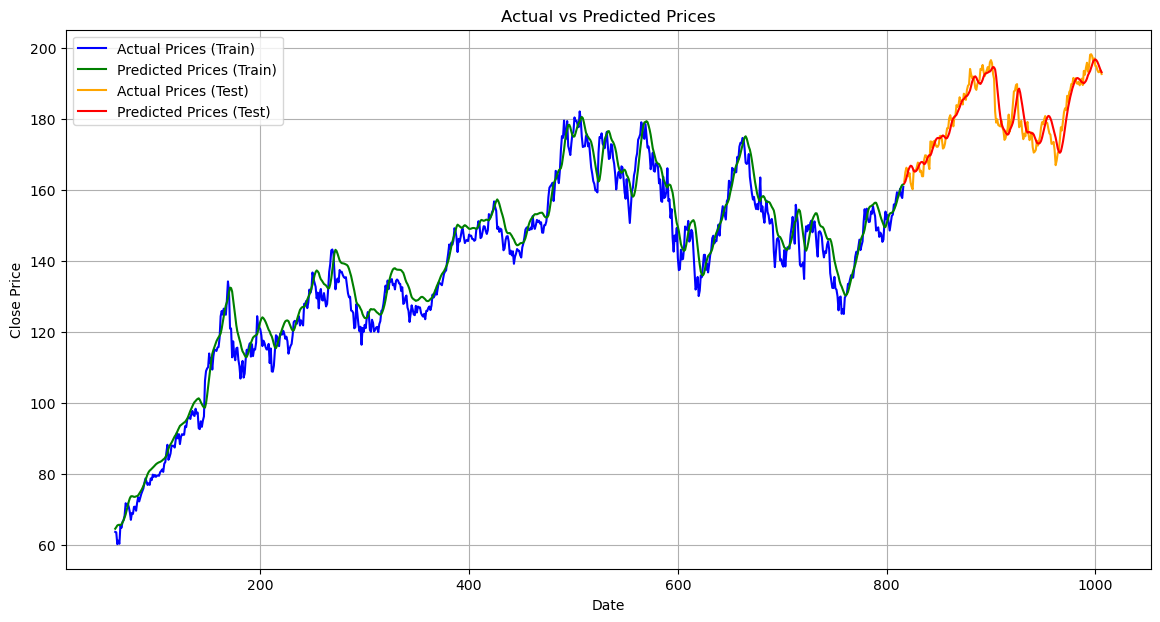

In [74]:
# Visualize the predictions vs. actual values
plt.figure(figsize=(14, 7))
plt.plot(data.index[time_step:train_size+time_step], y_train_original, label='Actual Prices (Train)', color='blue')
plt.plot(data.index[time_step:train_size+time_step], train_predictions, label='Predicted Prices (Train)', color='green')
plt.plot(data.index[train_size+time_step:], y_test_original, label='Actual Prices (Test)', color='orange')
plt.plot(data.index[train_size+time_step:], test_predictions, label='Predicted Prices (Test)', color='red')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [75]:
# To make real-time predictions
# Feed the predicted value back into the model
# This requires handling predictions one step at a time in a loop
# Therefore we add a rolling forecast function

def rolling_forecast(model, data, scaler, time_step):
    predictions = []
    input_seq = data[-time_step:]  # Start with the last 'time_step' data points
    for _ in range(30):  # Predict for the next 30 days
        pred = model.predict(input_seq.reshape(1, time_step, 1))
        predictions.append(pred[0][0])
        input_seq = np.append(input_seq[1:], pred[0])  # Slide the window
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

future_predictions = rolling_forecast(model, scaled_data, scaler, time_step)
print("Future predictions:", future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [76]:
# Save the Notebook Outputs
plt.savefig("model_loss.png")


<Figure size 640x480 with 0 Axes>

In [77]:
#Save the model 
model.save("lstm_stock_price_model.keras")
print("LSTM model saved as 'lstm_stock_price_model.keras'.")



LSTM model saved as 'lstm_stock_price_model.keras'.


In [78]:
# Suggestions for further improvement
# - Hyperparameter tuning for better performance (e.g., epochs, batch size, layers)
# - Use additional features like volume, SMA, etc.
# - Implement a rolling forecast mechanism for real-time predictions